In [ ]:
import requests
import os
import matplotlib.pyplot as plt


def download_file(url, save_path):
    """Download file from URL"""
    response = requests.get(url, verify=True)  # Disable SSL certificate verification
    with open(save_path, "wb") as f:
        f.write(response.content)


# Create a directory to store downloaded files
if not os.path.exists("DIMACS_instances"):
    os.makedirs("DIMACS_instances")

# URLs for the DIMACS instances
url_base = "https://iridia.ulb.ac.be/~fmascia/files/DIMACS"
families = [
    "brock",
    "C",
    "DSJC",
    "gen",
]
instances = {
    "C": ["C125.9", "C250.9", "C500.9"],
    "DSJC": ["DSJC500_5", "DSJC1000_5"],
    "gen": ["gen200_p0.9_44", "gen400_p0.9_55", "gen400_p0.9_65"],
    "brock": ["brock200_4"],
}

# Download the instances
for family in families:
    for instance in instances[family]:
        url = f"{url_base}/{instance}.clq"
        save_path = f"DIMACS_instances/{instance}.clq"  # Changed from .clq.gz to .clq
        print(f"Downloading {instance}.clq ...")  # Updated message
        download_file(url, save_path)

print("Download complete!")

Download complete!


In [ ]:
import numpy as np

In [ ]:
def load_dimacs_instances(instance_names):
    instances = {}
    for name in instance_names:
        file_path = f"DIMACS_instances/{name}.clq"
        try:
            with open(file_path, "r") as file:
                lines = file.readlines()
                adjacency_matrix = parse_dimacs_file(lines, name)
            instances[name] = adjacency_matrix
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return instances


def parse_dimacs_file(lines, filename):

    # Initialize variables to store vertices and edges
    vertices = set()
    edges = []

    # Initialize num_vertices
    num_vertices = None

    # Process each line in the file
    for line in lines:
        if line.startswith("c"):
            # Skip comment lines
            pass
        elif line.startswith("p"):
            if filename.startswith("C") and line.startswith("p col"):
                # Extract number of vertices from the header line
                parts = line.split()
                num_vertices = int(parts[2])
            elif (
                filename.startswith("DSJC")
                or filename.startswith("gen")
                or filename.startswith("brock200_4")
            ) and line.startswith("p edge"):
                # Extract number of vertices from the header line
                parts = line.split()
                num_vertices = int(parts[2])

        elif line.startswith("e"):
            # Extract edges from the 'e' lines
            _, vertex1, vertex2 = line.split()

            edges.append((int(vertex1), int(vertex2)))
            vertices.add(int(vertex1))
            vertices.add(int(vertex2))
        else:
            pass
    # Check if num_vertices is assigned
    if num_vertices is None:
        raise ValueError("Number of vertices not found in the DIMACS file.")

    # Initialize adjacency matrix
    adjacency_matrix = np.zeros((num_vertices, num_vertices), dtype=int)

    # Fill adjacency matrix based on the extracted edges
    for edge in edges:
        adjacency_matrix[edge[0] - 1, edge[1] - 1] = 1
        adjacency_matrix[edge[1] - 1, edge[0] - 1] = 1  # Assuming undirected graph

    return adjacency_matrix

In [ ]:
# List of DIMACS instance names
instance_names = ["C125.9", "DSJC500_5", "gen200_p0.9_44", "DSJC1000_5", "brock200_4"]

# Load DIMACS instances
instances = load_dimacs_instances(instance_names)

In [ ]:
import scipy

def line_search(gradient_func, x, direction):
    def objective(alpha):
        return gradient_func(x + alpha * direction) @ direction
    step_size = scipy.optimize.minimize_scalar(objective).x
    return step_size

In [ ]:
import numpy as np
import functools


def phi_B(x):
    return 0.5 * np.linalg.norm(x) ** 2


def grad_phi_B(x):
    return x


def phi_1(x, alpha_1, epsilon, p):
    norm_p = np.linalg.norm(x + epsilon, ord=p)
    return alpha_1 * (norm_p**p)


def grad_phi_1(x, alpha_1, epsilon, p):
    x_shifted = x + epsilon
    norm_p = np.linalg.norm(x_shifted, ord=p)
    grad_norm_p = (p * alpha_1 * (norm_p ** (p - 2))) * (x_shifted ** (p - 1))
    return grad_norm_p


def phi_2(x, alpha_2, beta):
    return alpha_2 * np.sum(np.exp(-beta * x) - 1)


def phi_2_gradient(x, alpha_2, beta):
    return -alpha_2 * beta * np.exp(-beta * x)


# Parameters
p = 3
epsilon = 10e-9
alpha_1_max = 2 / (p * (p - 1) * (1 + epsilon) ** (p - 2))
beta = 5


def frank_wolfe_max_clique(A, grad_phi, epsilon=1e-6, max_iter=1000):
    n = A.shape[0]

    # Initialize x0 as a random feasible point
    x = np.random.rand(n)
    x /= np.sum(x)  # Normalize to make it a probability vector
    # x = np.zeros(n)
    # x[start] = 1

    for k in range(max_iter):
        # Gradient computation
        grad = -2 * A @ x - grad_phi(x)

        # Linear Minimization Oracle (LMO)
        s = np.zeros(n)
        s[np.argmin(grad)] = 1

        # Step size determination
        gamma = 2 / (k + 2)

        # Update
        x_next = x + gamma * (s - x)

        # Convergence check
        if np.linalg.norm(x_next - x) < epsilon:
            break

        x = x_next

    return x

In [ ]:
import numpy as np


def find_m(arr, threshold_factor=0.5):

    # Filter out the values close to zero
    non_zero_values = arr[arr > threshold_factor * np.mean(arr[arr > 0])]

    estimate_inverse_m = np.median(non_zero_values)

    # Calculate m as the reciprocal of the estimate
    m = 1 / estimate_inverse_m

    return m

# Choose your matrix, your phi and some other hyperparameter

In [ ]:
# Choose your matrix
adjacency_matrix = instances["DSJC500_5"]

# Choose your alpha (right now using a random alpha_1 in the range of formula (32))
alpha_1 = np.random.uniform(0, alpha_1_max)
alpha_2 = np.random.uniform(0, 2 / beta**2)

# Computing the phi with your params
grad_phi_1_partial = functools.partial(
    grad_phi_1, alpha_1=alpha_1, epsilon=epsilon, p=p
)
grad_phi_2_partial = functools.partial(phi_2_gradient, alpha_2=alpha_2, beta=beta)

# Choose your phi:
my_phi = grad_phi_2_partial  # grad_phi_B or grad_phi_1_partial or grad_phi_2_partial

In [ ]:
clique_vector = frank_wolfe_max_clique(adjacency_matrix, my_phi)
print("Clique vector:\n", clique_vector)

m = find_m(clique_vector)
print("Size of biggest clique found:", m)

Clique vector:
 [0.        0.        0.0993007 0.0995005 0.        0.        0.
 0.        0.        0.        0.        0.0997003 0.0999001 0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.1000999 0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.1002997 0.        0. 

# Other Franke Wolfe variants


In [ ]:
def pairwise_frank_wolfe_max_clique(A, grad_phi, epsilon=1e-6, max_iter=1000):
    n = A.shape[0]

    # Initialize x0 as a random feasible point
    x = np.random.rand(n)
    x /= np.sum(x)  # Normalize to make it a probability vector

    for k in range(max_iter):
        # Gradient computation
        grad = -2 * A @ x - grad_phi(x)

        # Linear Minimization Oracle (LMO)
        s = np.zeros(n)
        s[np.argmin(grad)] = 1

        # Pairwise step
        d = s - x
        gamma = np.min([-np.dot(grad, d) / np.dot(d, d), 1.0])

        # Update
        x_next = x + gamma * d

        # Convergence check
        if np.linalg.norm(x_next - x) < epsilon:
            break

        x = x_next

    return x

In [ ]:
def away_step_frank_wolfe_max_clique(A, grad_phi, epsilon=1e-6, max_iter=1000):
    n = A.shape[0]

    # Initialize x0 as a random feasible point
    x = np.random.rand(n)
    x /= np.sum(x)  # Normalize to make it a probability vector

    for k in range(max_iter):
        # Gradient computation
        grad = -2 * A @ x - grad_phi(x)

        # Linear Minimization Oracle (LMO)
        s = np.zeros(n)
        s[np.argmin(grad)] = 1

        # Active set
        active_set = np.where(x > 0)[0]

        if len(active_set) > 0:
            # Away step
            a = np.zeros(n)
            a[active_set[np.argmax(grad[active_set])]] = 1

            # Determine step size for both Frank-Wolfe and away step
            d_fw = s - x
            d_a = x - a

            gamma_fw = np.min([-np.dot(grad, d_fw) / np.dot(d_fw, d_fw), 1.0])
            gamma_a = np.min(
                [
                    np.dot(grad, d_a) / np.dot(d_a, d_a),
                    x[active_set[np.argmax(grad[active_set])]]
                    / (1 - x[active_set[np.argmax(grad[active_set])]]),
                ]
            )

            # Determine which step to take
            if -np.dot(grad, d_fw) >= np.dot(grad, d_a):
                gamma = gamma_fw
                x_next = x + gamma * d_fw
            else:
                gamma = gamma_a
                x_next = x + gamma * d_a

        else:
            # Only Frank-Wolfe step is possible
            d = s - x
            gamma = np.min([-np.dot(grad, d) / np.dot(d, d), 1.0])
            x_next = x + gamma * d

        # Convergence check
        if np.linalg.norm(x_next - x) < epsilon:
            break

        x = x_next

    return x

In [ ]:
clique_vector = pairwise_frank_wolfe_max_clique(adjacency_matrix, my_phi)
print("Clique vector:\n", clique_vector)

m = find_m(clique_vector)
print("Size of biggest clique found:", m)

Clique vector:
 [9.42848118e-07 6.40062217e-07 1.33173605e-06 7.62728175e-07
 1.62746577e-06 1.35867627e-07 1.41479163e-06 1.00166258e-06
 2.02517651e-06 1.75357093e-06 2.47236336e-08 2.61645124e-07
 1.31156783e-06 9.97225155e-02 4.09325850e-07 3.09302990e-07
 1.23433059e-06 3.77545615e-07 3.37359924e-07 9.49916959e-07
 1.34219094e-06 1.00679055e-06 1.32507222e-07 7.14638393e-07
 1.25527136e-06 5.22002562e-07 3.49046241e-07 7.55059656e-07
 7.84428823e-08 9.02392096e-07 1.66714855e-06 2.70683043e-08
 6.06583673e-07 1.50542183e-06 1.25323621e-06 8.35061350e-07
 1.09459418e-07 1.85948336e-06 1.92855484e-06 2.08647091e-06
 1.59801151e-06 1.93230449e-06 9.95137793e-07 1.94048740e-06
 6.37785197e-07 1.74952822e-07 5.64894880e-07 6.77884800e-07
 1.98159961e-06 1.00155444e-01 2.04235586e-06 1.01304247e-06
 1.95273264e-06 9.98094192e-02 5.80779362e-07 1.56484525e-06
 1.94534212e-06 2.11294396e-06 1.38224609e-06 1.72673772e-06
 1.44097966e-06 1.58089087e-06 1.78696408e-06 1.39734979e-06
 6.78436

In [ ]:
clique_vector = away_step_frank_wolfe_max_clique(adjacency_matrix, my_phi)
print("Clique vector:\n", clique_vector)

m = find_m(clique_vector)
print("Size of biggest clique found:", m)

Clique vector:
 [1.26653284e-06 1.53384558e-06 2.05514973e-07 7.19464708e-07
 1.16815217e-06 1.42152984e-06 2.00703910e-06 1.61761327e-06
 7.11501183e-07 1.72253862e-06 1.15229350e-07 1.11457850e-01
 7.05241063e-07 1.10732412e-01 1.72586097e-06 9.60366032e-07
 8.41933697e-07 7.98651729e-07 4.44227173e-07 1.37241118e-06
 1.73905201e-06 3.00496610e-07 1.95304436e-06 8.32242461e-07
 3.41849049e-07 5.71813122e-07 1.65223241e-06 1.82966709e-06
 9.38707202e-07 1.06834299e-06 9.62537660e-07 6.13198358e-07
 1.39209713e-06 1.17576520e-06 3.36345291e-09 1.64961886e-06
 4.78335623e-07 7.31646336e-07 6.24132022e-07 1.09780112e-06
 1.59272257e-06 1.79309611e-06 1.35261561e-06 1.48128827e-06
 1.35800516e-06 5.50362105e-07 1.20396137e-06 1.63105904e-06
 9.64729029e-07 1.64396662e-06 5.67405028e-07 3.55316327e-07
 1.09092885e-06 5.85423910e-07 4.19243894e-07 1.17321183e-06
 3.11146266e-07 2.00724702e-06 1.41150024e-06 2.58226120e-07
 1.87301726e-06 3.13062938e-07 7.88791188e-08 1.99888219e-06
 4.10298

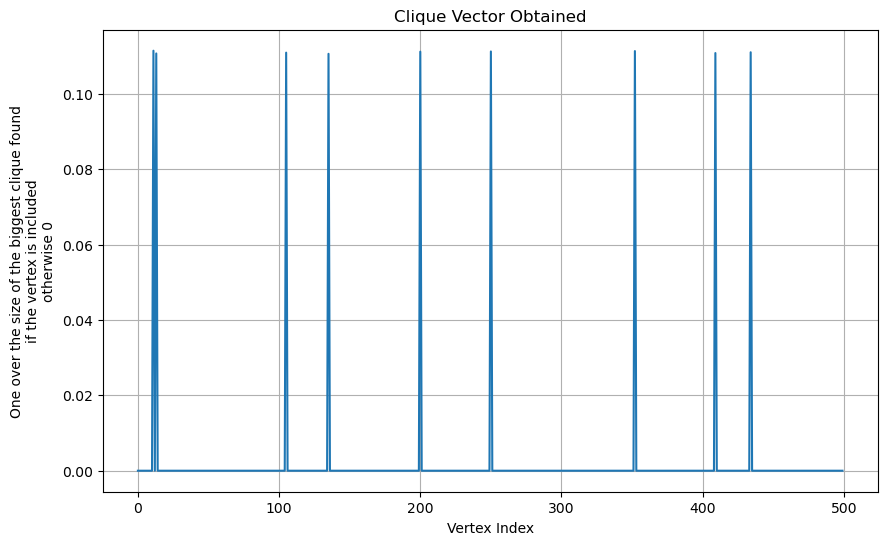

In [ ]:
# Plotting the clique vector obtained
plt.figure(figsize=(10, 6))
plt.plot(clique_vector)
plt.title("Clique Vector Obtained")
plt.xlabel("Vertex Index")
plt.ylabel(
    "One over the size of the biggest clique found\nif the vertex is included\notherwise 0"
)
plt.grid(True)
plt.show()

# 100 times to measure means and variance

In [ ]:
import time

# The Datasets
instance_names = ["DSJC500_5", "gen200_p0.9_44", "brock200_4"]

# loading them
adjacency_matrices = {
    "DSJC500_5": instances["DSJC500_5"],
    "gen200_p0.9_44": instances["gen200_p0.9_44"],
    "brock200_4": instances["brock200_4"],
}

# the 3 algos
fw_algorithms = {
    "vanilla": frank_wolfe_max_clique,
    "pairwise": pairwise_frank_wolfe_max_clique,
    "away_step": away_step_frank_wolfe_max_clique,
}

# l2, other and l0
phi_functions = {
    "phi_B": grad_phi_B,
    "phi_1": grad_phi_1_partial,
    "phi_2": grad_phi_2_partial,
}

# Initialize nested dict for res storage
results = {}

# Run the tests
for instance_name in instance_names:
    results[instance_name] = {}
    adjacency_matrix = adjacency_matrices[instance_name]

    for algo_name, fw_algo in fw_algorithms.items():
        results[instance_name][algo_name] = {}

        for phi_name, phi_func in phi_functions.items():
            results[instance_name][algo_name][phi_name] = {"results": [], "times": []}

            for i in range(100):
                start_time = time.time()
                clique_vector = fw_algo(
                    adjacency_matrix, phi_func, epsilon=1e-6, max_iter=1000
                )
                end_time = time.time()
                m = find_m(clique_vector)

                results[instance_name][algo_name][phi_name]["results"].append(m)
                results[instance_name][algo_name][phi_name]["times"].append(
                    end_time - start_time
                )

# saving it in case of crash
import json

with open("results.json", "w") as f:
    json.dump(results, f)

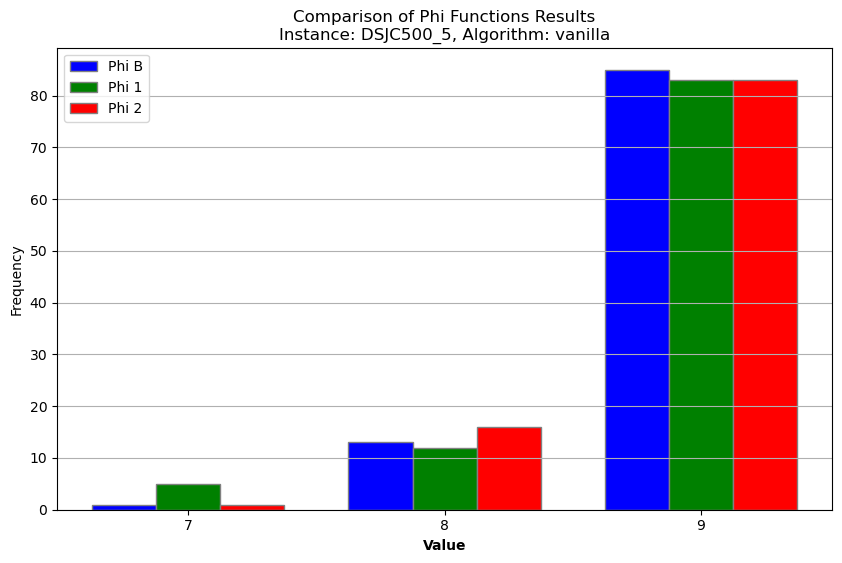

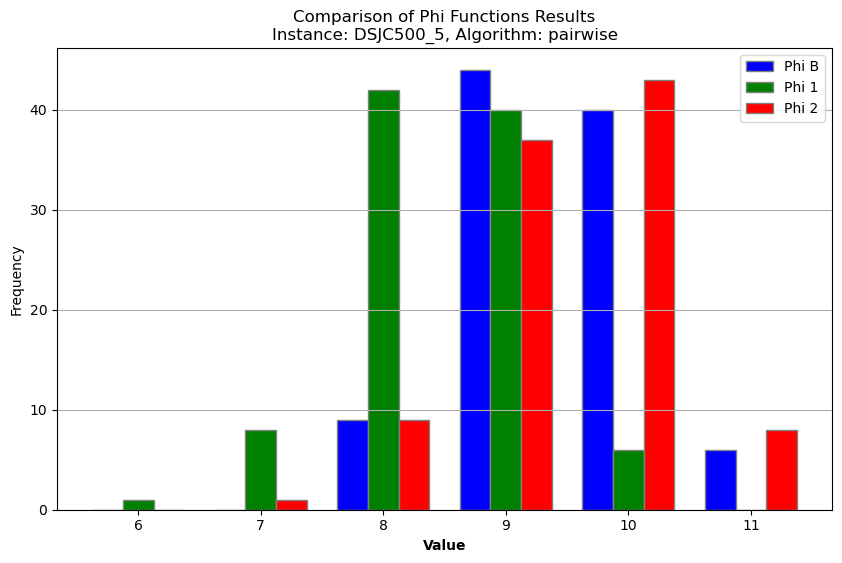

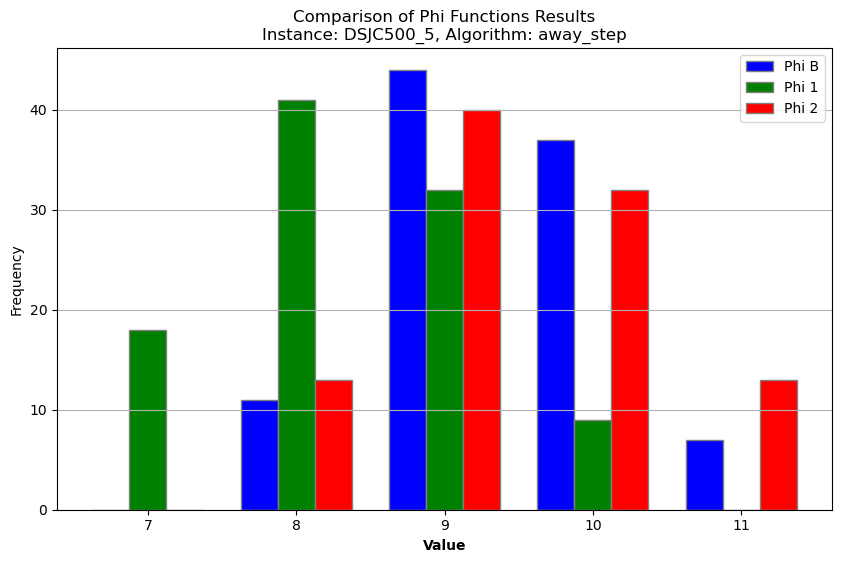

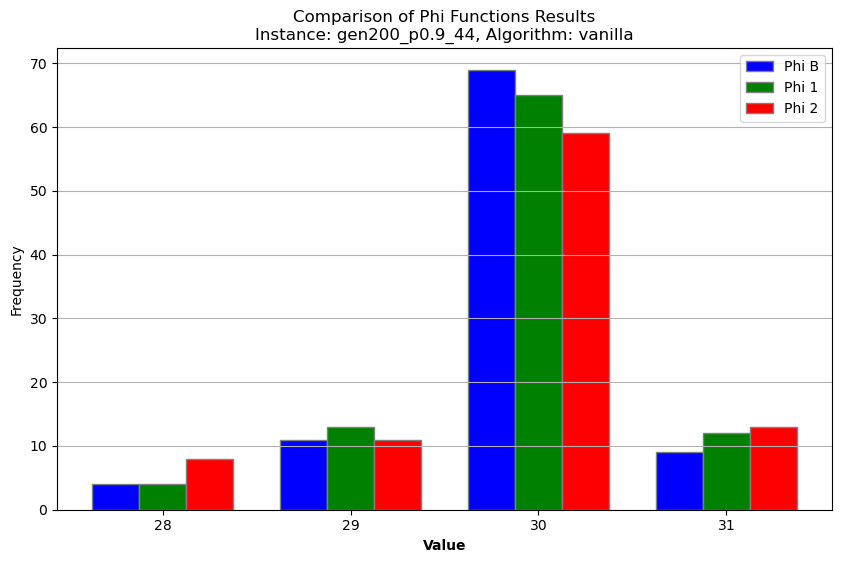

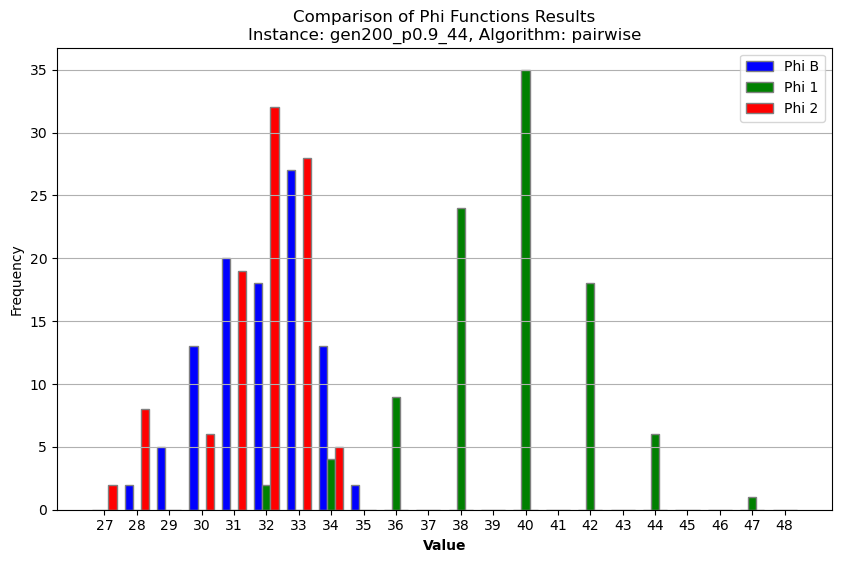

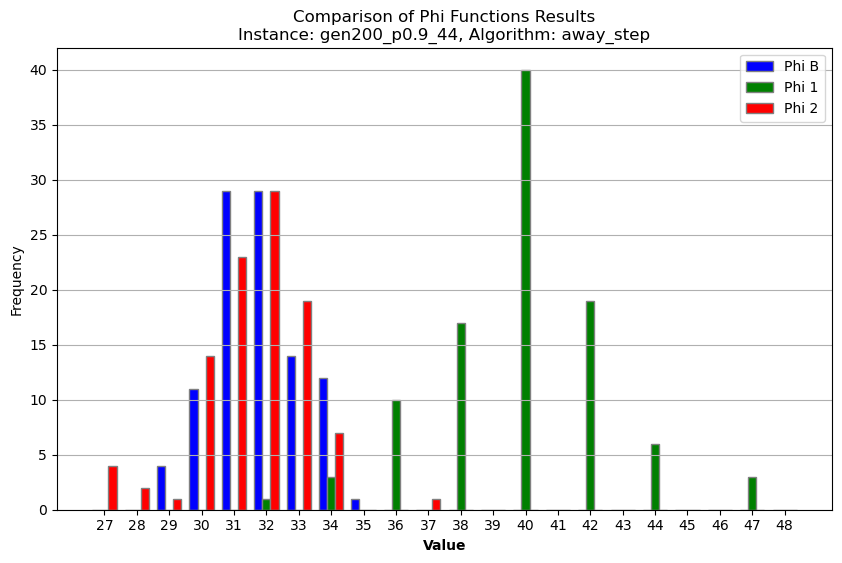

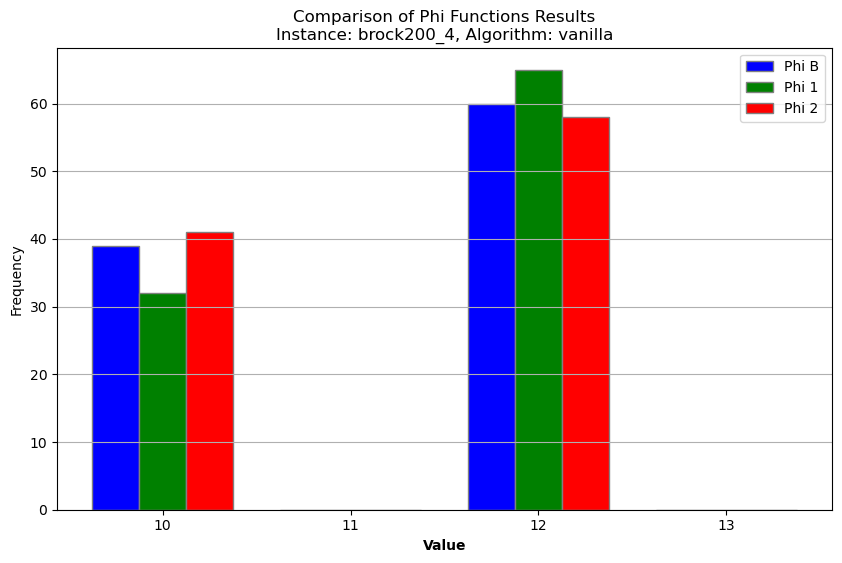

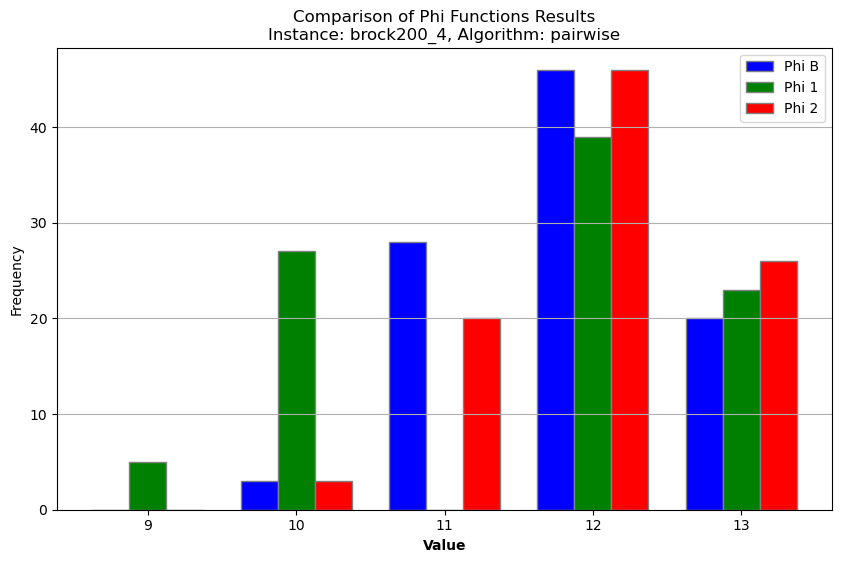

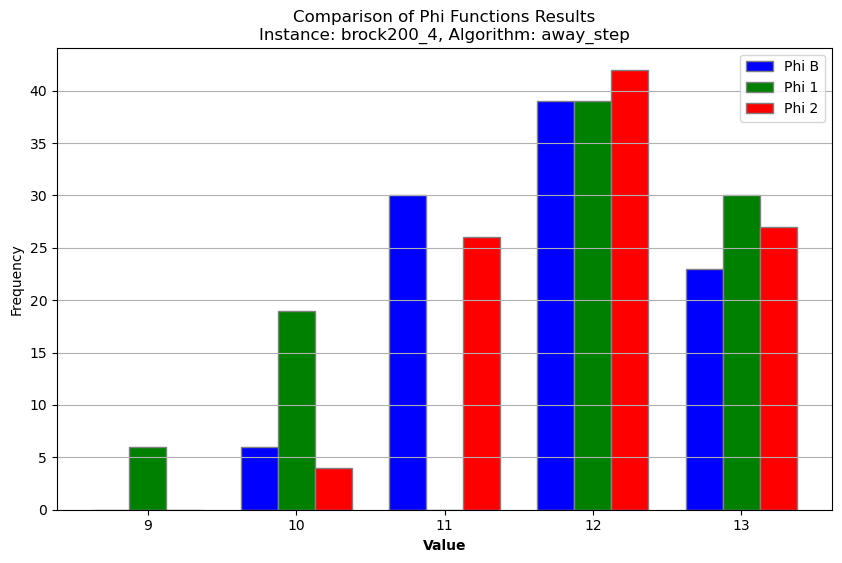

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_results(results, instance_name, algo_name):

    results_vanilla = results[instance_name][algo_name]["phi_B"]["results"]
    results_phi_1 = results[instance_name][algo_name]["phi_1"]["results"]
    results_phi_2 = results[instance_name][algo_name]["phi_2"]["results"]

    min_value = int(min(min(results_vanilla), min(results_phi_1), min(results_phi_2)))
    max_value = int(max(max(results_vanilla), max(results_phi_1), max(results_phi_2)))

    bins = np.arange(min_value, max_value + 1)
    counts_vanilla = np.histogram(results_vanilla, bins=bins)[0]
    counts_phi_1 = np.histogram(results_phi_1, bins=bins)[0]
    counts_phi_2 = np.histogram(results_phi_2, bins=bins)[0]

    bar_width = 0.25
    r1 = np.arange(len(bins) - 1)
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    plt.figure(figsize=(10, 6))

    plt.bar(
        r1,
        counts_vanilla,
        color="blue",
        width=bar_width,
        edgecolor="grey",
        label="Phi B",
    )
    plt.bar(
        r2,
        counts_phi_1,
        color="green",
        width=bar_width,
        edgecolor="grey",
        label="Phi 1",
    )
    plt.bar(
        r3, counts_phi_2, color="red", width=bar_width, edgecolor="grey", label="Phi 2"
    )

    plt.xlabel("Value", fontweight="bold")
    plt.xticks([r + bar_width for r in range(len(r1))], bins[:-1])

    plt.title(
        f"Comparison of Phi Functions Results\nInstance: {instance_name}, Algorithm: {algo_name}"
    )
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(axis="y")
    plt.show()


# Generate the plots for each combination of dataset and algorithm
for instance_name in instance_names:
    for algo_name in fw_algorithms.keys():
        plot_results(results, instance_name, algo_name)

In [ ]:
def print_statistics(results):
    for instance_name in results.keys():
        print(f"Dataset: {instance_name}")

        for algo_name in results[instance_name].keys():
            print(f"Algorithm: {algo_name}")

            for phi_name in results[instance_name][algo_name].keys():
                times = results[instance_name][algo_name][phi_name]["times"]
                result_values = results[instance_name][algo_name][phi_name]["results"]

                avg_time = np.mean(times)
                mean_result = np.mean(result_values)
                var_result = np.var(result_values)

                print(f"Phi Function: {phi_name}")
                print(f"Average time: {avg_time:.6f} seconds")
                print(f"Mean result: {mean_result:.6f}")
                print(f"Variance of result: {var_result:.6f}")
                print("\n")


# Call the function to print statistics
print_statistics(results)

Dataset: DSJC500_5
Algorithm: vanilla
Phi Function: phi_B
Average time: 0.545097 seconds
Mean result: 9.420005
Variance of result: 0.583595


Phi Function: phi_1
Average time: 0.553676 seconds
Mean result: 9.380004
Variance of result: 0.775597


Phi Function: phi_2
Average time: 0.675780 seconds
Mean result: 9.380005
Variance of result: 0.615596


Algorithm: pairwise
Phi Function: phi_B
Average time: 0.635369 seconds
Mean result: 9.465092
Variance of result: 0.608545


Phi Function: phi_1
Average time: 0.567732 seconds
Mean result: 9.509932
Variance of result: 0.769855


Phi Function: phi_2
Average time: 0.612917 seconds
Mean result: 9.544388
Variance of result: 0.769402


Algorithm: away_step
Phi Function: phi_B
Average time: 0.543107 seconds
Mean result: 9.435084
Variance of result: 0.665455


Phi Function: phi_1
Average time: 0.510094 seconds
Mean result: 9.319921
Variance of result: 0.757452


Phi Function: phi_2
Average time: 0.514406 seconds
Mean result: 9.524272
Variance of resu